
IMPORTANT! : All the data are not uploaded to Google Drive and therefore are not available on Google Collab and for this notebook. this is due to data space constraints.

# MNIST classification with RBM (Assignment 3)

In this section we will load the data required for the study into memory and perform some necessary pre-processing steps.

We import all useful libraries for the study and create a useful function to visualise the data and results.

In [ ]:
from skimage import io
import plotly.express as px
from matplotlib import pyplot as plt
import numpy as np
import pathlib as pth
import os
import random
import pandas as pd
import json
import sklearn.metrics as skm
import sklearn.tree as skt
import sklearn.svm as sks
import time
import seaborn as sns

DATASET_DIR = pth.Path('../data')
RANDOM_STATE = 12
random.seed(RANDOM_STATE)

def plot_images(images, titles=[], rows=1, cols=1, figsize=(10,10), **kwargs):
    '''
        To easily show n images in a list in a unique plot
    '''
    num_images = len(images)
    total_plots = rows * cols

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = np.array([axes])

    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i], **kwargs)
        ax.set_title(titles[i])
        ax.axis('off')
    for j in range(num_images, total_plots):
        axes[j].axis('off')

    plt.show()

We load the MNIST [http://yann.lecun.com/exdb/mnist/] dataset into memory, which consists of a total of 70.000 28x28 grayscale images representing handwritten digits from 0 to 9. The data are divided into training set (60000 samples) and test set (10000 samples).
We now also create a new data set, called the energy subset, which is a representative subset of the training set, well balanced across classes, of the same size as the test, which is used later in training to monitor learning and over-fitting.

In [ ]:
energy_subset_sample = 1000
energy_subset = []
training_set = []
test_set = []
for sub_dir in (DATASET_DIR / 'MNIST/training').iterdir():
    #print(sub_dir.name)
    imgs = [(io.imread(img), sub_dir.name) for img in sub_dir.iterdir() if img.suffix == '.png']
    energy_subset.extend(random.sample(imgs, energy_subset_sample))
    training_set.extend(imgs)
for sub_dir in (DATASET_DIR / 'MNIST/testing').iterdir():
    #print(sub_dir.name)
    imgs = [(io.imread(img), sub_dir.name) for img in sub_dir.iterdir() if img.suffix == '.png']
    test_set.extend(imgs)


We shuffle the datasets, keeping track of the correct labels for each sample, to avoid any possible bias due to the order of the data. We also decompose the images into one-dimensional vectors to facilitate the learning process, as RBM operates on binary vectors.

In [ ]:
random.shuffle(training_set)
random.shuffle(test_set)
random.shuffle(energy_subset)

training_lables = np.array([i for x, i in training_set])
test_lables = np.array([i for x, i in test_set])
energy_subset_lables = np.array([i for x, i in energy_subset])

training_set = np.array([x.flatten() for x, i in training_set])
test_set = np.array([x.flatten() for x, i in test_set])
energy_subset = np.array([x.flatten() for x, i in energy_subset])

'''
training_set = training_set / np.max(training_set)
test_set = test_set / np.max(test_set)
energy_subset = energy_subset / np.max(energy_subset)
'''
'''
threshold = 255/2
training_set = np.where(training_set > threshold, 1, 0)
test_set = np.where(test_set > threshold, 1, 0)
energy_subset = np.where(energy_subset > threshold, 1, 0)''';

As a final pre-processing step, we normalise the obtained data sets by dividing them by the maximum value they contain.

In [ ]:
training_set = training_set / 255
test_set = test_set / 255
energy_subset = energy_subset / 255

Here we show a simple image representative of the entire dataset, where each pixel contains the average value of the same pixel across the entire dataset. It thus represents the 'expected image' of the probability distribution described by the data set. As expected, it is interesting to note that the representation is identical for all 3 sets identified above. Furthermore, the constructed vector associated with the training set will be useful in the learning process to initialise the value of the bias vector for the visible units.

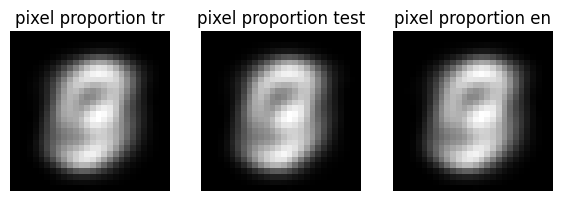

In [ ]:
visible_proportion_tr = np.sum(training_set, axis=0) / len(training_set) + 0.5 / len(training_set)
visible_proportion_test = np.sum(test_set, axis=0) / len(training_set) + 0.5 / len(training_set)
visible_proportion_en = np.sum(energy_subset, axis=0) / len(training_set) + 0.5 / len(training_set)
plot_images([np.reshape(x, (28,28)) for x in [visible_proportion_tr,visible_proportion_test,visible_proportion_en]],
            ['pixel proportion tr', 'pixel proportion test', 'pixel proportion en'], 1, 3, figsize=(7,2.5), cmap='grey')

Here we display some randomly extracted samples from the test_set.

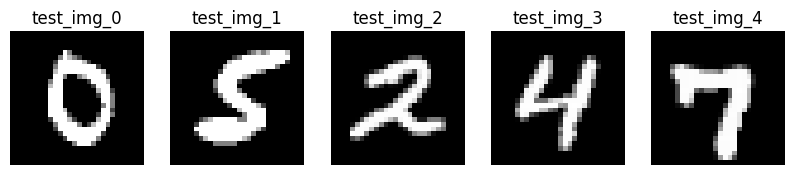

In [ ]:
test_images = [np.reshape(x, (28,28)) for x in test_set[:5]]
test_images_tr = [np.reshape(x, (28,28)) for x in training_set[:5]]
plot_images(test_images, ['test_img_' + str(i) for i in range(5)], 1, 5, cmap='grey')

Boltzmann machines can be trained so that the equilibrium distribution tends to an arbitrary distribution of binary vectors, in our case represented by the dataset. Specifically, each image does not represent a binary vector, but rather a distribution of vectors, and each pixel represents the probability of that pixel being 1. Therefore, in the RBM training phase, we will extract a binary vector from each image, as shown below with reference to the samples shown above.

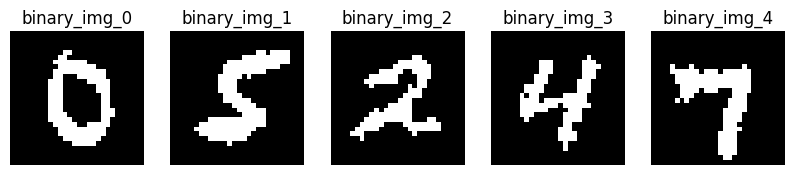

In [ ]:
test = [(x > np.random.rand(*x.shape)).astype(int) for x in test_images]
plot_images(test, ['binary_img_' + str(i) for i in range(5)], 1, 5, cmap='grey')

# RBM

This section contains the implementation of the class representing a Restricted Boltzman Machine with all useful methods for its use and the Contrastive-Divergence 1 training algorithm.

First we implemented useful functions to calculate the sigmoid, the reconstruction error via MSE and the free energy associated with a vector of visible states.

The free energy of visible vector v is the energy that a single configuration would need to have in order to have the same probability as all of the configurations that contain v. During the learning phase, it is very useful to calculate and monitor the difference between the free energy of the validation set and the free energy of a representative subset of the training set. In the case of overfitting, this difference will tend to increase [https://www.cs.toronto.edu/%7Ehinton/absps/guideTR.pdf].

We therefore explain here that the energy subset is a set of 10,000 samples, divided into 1000 for each output class, randomly selected from the training set.

In [ ]:
def sigmoid(x):
    """
    Compute the sigmoid function for a given input.

    Parameters:
    -----------
    x : float or array-like
        The input of the sigmoid.

    Returns:
    --------
    float or array-like: Sigmoid of the input value(s).
    """
    return 1 / (1 + np.exp(-x))

def MSE(data, reconstructed_data):
    """
    Calculates the Mean Squared Error (MSE) loss.

    Parameters:
    -----------
    data : array-like
        Original data.
    reconstructed_data : array-like
        Reconstructed data.

    Returns:
    --------
    float
        The MSE between the original and reconstructed data.
    """
    return np.mean(np.mean((data - reconstructed_data)**2))

def free_energy(V, W, v_b, h_b):
    """
    Calculates the free energy of an Unsupervised Neural Network model.

    Parameters:
    -----------
    V : array-like
        Input of the model.
    W : array-like
        Connection weights between input and hidden nodes.
    v_b : array-like
        Bias of the inputs.
    h_b : array-like
        Bias of the hidden nodes.

    Returns:
    --------
    float
        The free energy of the model.
    """
    X = h_b + np.matmul(V, W)
    return -np.dot(V, v_b) - np.sum(np.log(1 + np.exp(X)), axis=1)

The implementation of the RBM is very simple and straightforward and does not differ much from a standard implementation. Some of the most notable features are
- The implementation of early stopping based on the reconstruction error of the validation set; in case of early stopping, the network tries to use the past parameter values by averaging between several iterations.
- The presence of momentum and exponential learning rate decay
- Implementation of the CD-1 learning algorithm
- The ability to serialise and deserialise the network in a json file.

In [ ]:
class RBM:
    """
    Restricted Boltzmann Machine class.
    """

    default_hyperparameters_values = {
              'batch_size':10, # batch mode
              'max_epochs':100,
              'learning_rate':0.01,
              'alpha_momentum':0.0,
              'lr_decay_starting_epoch':-1,
              'lr_decay_mul':0.01,
              'weight_decay':0,
              'patience':10,
              'error_sensibility':0.01,
              'min_epochs':100,
              'early_stop_param_average':2
    }

    def __init__(self, n_hidden_units:int, n_visible_units:int, visible_units_prop:np.ndarray=None, hidden_biases_init:float=-4, hyperparams:dict=default_hyperparameters_values):
        """
        Initializes the Restricted Boltzmann Machine (RBM).

        Parameters:
        -----------
        n_hidden_units : int
            Number of hidden units in the RBM.
        n_visible_units : int
            Number of visible units in the RBM.
        visible_units_prop : np.ndarray, optional
            Propensity of each visible unit to be activated (default is None, all set to 0.2).
        hidden_biases_init : float, optional
            Initialization value for the biases of hidden units (default is -4).
        hyperparams : dict, optional
            Dictionary containing hyperparameters for the RBM training (default is default_hyperparameters_values).
        """
        self.initialize_weights(n_hidden_units, hidden_biases_init, n_visible_units, visible_units_prop)
        self.set_hyperparameters(**hyperparams)

    def initialize_weights(self,  n_hidden_units:int, hidden_biases_init:float, n_visible_units:int, visible_units_prop:np.ndarray):
        """
        Initialize weights and biases for the RBM.

        Parameters:
        -----------
        n_hidden_units : int
            Number of hidden units.
        hidden_biases_init : float
            Initialization value for the biases of hidden units.
        n_visible_units : int
            Number of visible units.
        visible_units_prop : np.ndarray
            Propensity of each visible unit to be activated.
        """
        self.n_hidden_units = n_hidden_units
        self.n_visible_units = n_visible_units

        self.W = np.random.normal(0.0, 0.01, (self.n_visible_units, self.n_hidden_units))

        if visible_units_prop is None:
            visible_units_prop = np.array([0.2]*n_visible_units)
        self.v_b = np.log(visible_units_prop/(1-visible_units_prop))

        self.h_b = np.array([hidden_biases_init]*n_hidden_units)

    def set_weights(self, W:np.ndarray, v_b:np.ndarray, h_b:np.ndarray):
        """
        Set weights and biases for the RBM.

        Parameters:
        -----------
        W : np.ndarray
            Weight matrix.
        v_b : np.ndarray
            Visible biases.
        h_b : np.ndarray
            Hidden biases.
        """
        self.W = W.copy()
        self.v_b = v_b.copy()
        self.h_b = h_b.copy()

    def set_hyperparameters(self,
              batch_size:int = 10, # batch mode
              max_epochs:int = 100,
              learning_rate:float = 0.01,
              alpha_momentum:float = 0.0,
              lr_decay_starting_epoch:int=-1,
              lr_decay_mul:float=0.01,
              weight_decay:float=0,
              patience:int=10,
              error_sensibility:float=0.01,
              min_epochs:int=100,
              early_stop_param_average:int=1):
        """
        Set hyperparameters for the RBM training.

        Parameters:
        -----------
        batch_size : int
            Size of each batch during training.
        max_epochs : int
            Maximum number of epochs for training.
        learning_rate : float
            Learning rate for weight updates.
        alpha_momentum : float
            Momentum for weight updates.
        lr_decay_starting_epoch : int
            Epoch from which learning rate decay starts.
        lr_decay_mul : float
            Multiplier for learning rate decay.
        weight_decay : float
            Weight decay rate.
        patience : int
            Patience parameter for early stopping.
        error_sensibility : float
            Sensibility parameter for early stopping.
        min_epochs : int
            Minimum number of epochs for training.
        early_stop_param_average : int
            Parameter for averaging in early stopping.
        """
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.learning_rate = learning_rate
        self.alpha_momentum = alpha_momentum
        self.lr_decay_starting_epoch = lr_decay_starting_epoch
        self.lr_decay_mul = lr_decay_mul
        self.weight_decay = weight_decay
        self.patience = patience
        self.error_sensibility = error_sensibility
        self.min_epochs = min_epochs
        self.early_stop_param_average = early_stop_param_average

    def train(self, training_set, validation_set, training_subset):
        """
        Train the RBM.

        Parameters:
        -----------
        training_set : np.ndarray
            Training dataset.
        validation_set : np.ndarray
            Validation dataset.
        training_subset : np.ndarray
            Subset of training dataset.

        Returns:
        --------
        dict
            Statistics of the training process.
        """
        if self.early_stop_param_average >= self.patience:
            self.early_stop_param_average = self.patience/2
        if (self.patience + self.early_stop_param_average) > self.min_epochs:
            self.min_epochs = self.patience + self.early_stop_param_average + 1

        training_set_length = len(training_set)
        self.epochs = 0
        stats = {
                 'batch_size':self.batch_size,
                 'max_epochs':self.max_epochs,
                 'learning_rate':self.learning_rate,
                 'alpha_momentum':self.alpha_momentum,
                 'lr_decay_starting_epoch':self.lr_decay_starting_epoch,
                 'lr_decay_mul':self.lr_decay_mul,
                 'lr_weight_decay':self.weight_decay,
                 'patience':self.patience,
                 'error_sensibility':self.error_sensibility,
                 'min_epochs':self.min_epochs,
                 'early_stop_epochs_average':self.early_stop_param_average,
                 'metrics' : {'tr_error' : [], 'val_error' : [], 'energy_gap' : []}}

        prev_state_error = [None] * (self.patience + 1)
        prev_error = [np.inf] * (self.patience + 1)

        delta_W = 0
        delta_v_b = 0
        delta_h_b = 0

        batch_index = 0
        start_time = time.time()
        epoch_time = 1
        while (self.epochs < self.max_epochs):
            # training loop

            # extracting the batch
            if batch_index + self.batch_size > training_set_length:
                batch = np.append(training_set[batch_index:],
                                  training_set[: (batch_index + self.batch_size)%training_set_length], axis=0)
            else:
                batch = training_set[batch_index: batch_index + self.batch_size]
            batch_index += self.batch_size

            # computing wake part
            visible_state_0 = (batch > np.random.rand(*batch.shape)).astype(int)
            comput_var = np.dot(visible_state_0, self.W) + self.h_b
            hidden_prob_0 = 1 / (1 + np.exp(-comput_var))

            hidden_state_0 = (hidden_prob_0 > np.random.rand(*hidden_prob_0.shape)).astype(int)
            wake = np.dot(visible_state_0.T, hidden_state_0)

            # computing dream part
            comput_var = np.dot(hidden_state_0, self.W.T) + self.v_b
            visible_prob_1 = 1 / (1 + np.exp(-comput_var))
            visible_state_1 = (visible_prob_1 > np.random.rand(*visible_prob_1.shape)).astype(int)
            comput_var = np.dot(visible_state_1, self.W) + self.h_b
            hidden_prob_1 = 1 / (1 + np.exp(-comput_var))
            dream = np.dot(visible_prob_1.T, hidden_prob_1)

            # compute and normalize the accumulated deltas dividing by the batch size
            grad_step_W = (wake - dream) / self.batch_size
            grad_step_v_b = np.sum(visible_state_0 - visible_state_1, axis=0) / self.batch_size
            grad_step_h_b = np.sum(hidden_prob_0 - hidden_prob_1, axis=0) / self.batch_size

            # compute the final weight update
            delta_W = self.learning_rate * grad_step_W + self.alpha_momentum * delta_W - self.learning_rate * self.weight_decay * self.W
            delta_v_b = self.learning_rate * grad_step_v_b + self.alpha_momentum * delta_v_b
            delta_h_b = self.learning_rate * grad_step_h_b + self.alpha_momentum * delta_h_b

            # weights and bias update
            self.W += delta_W
            self.v_b += delta_v_b
            self.h_b += delta_h_b

            if batch_index >= training_set_length:
                # end of the epoch

                # weight decay only start at a certain specified epoch
                if self.lr_decay_starting_epoch < self.epochs:
                    self.learning_rate = self.learning_rate*self.lr_decay_mul

                # updating the batch index
                self.epochs += 1
                batch_index = batch_index%training_set_length

                # computing and printing useful stats
                tr_error = MSE(self.reconstruct(training_set), training_set)
                stats['metrics']['tr_error'].append(tr_error)

                # learning time
                epoch_time = (time.time() - start_time) * 0.25 + epoch_time*0.75
                total_time_prev = (self.max_epochs - self.epochs)*epoch_time
                to_print = f'el_time {time.time() - start_time:.2f}s | rem_time: {total_time_prev/60:.2f}m | '
                start_time = time.time()

                to_print += 'epoch ' + str(self.epochs) + '/' + str(self.max_epochs) + ' | '
                to_print += f'rec_error_tr: {tr_error:.6f} | '

                # check on validation set if is not None
                if not (validation_set is None):
                    val_error = MSE(self.reconstruct(validation_set), validation_set)
                    stats['metrics']['val_error'].append(tr_error)
                    to_print += f'rec_error_val: {val_error:.6f} | '

                    if not (training_subset is None):
                        val_free_en = np.mean(free_energy(validation_set, self.W, self.v_b, self.h_b))
                        tr_free_en = np.mean(free_energy(training_subset, self.W, self.v_b, self.h_b))

                        to_print += f'energy_gap: {abs(tr_free_en - val_free_en):.6f} | '
                        stats['metrics']['energy_gap'].append(abs(tr_free_en - val_free_en))

                print(to_print)

                # checks for early stopping
                if not (validation_set is None) and self.patience > 0:
                    index_error = self.early_stop_param_average
                    prev_error_avg = np.mean(prev_error[ : 2*index_error + 1])

                    if self.epochs > self.min_epochs and (val_error - prev_error_avg)/prev_error_avg > self.error_sensibility:
                        # averaging parameter's values between epochs if early stop occurs
                        self.W = np.mean([el[0] for el in prev_state_error[:2*index_error + 1]], axis=0)
                        self.h_b = np.mean([el[1] for el in prev_state_error[:2*index_error + 1]], axis=0)
                        self.v_b = np.mean([el[2] for el in prev_state_error[:2*index_error + 1]], axis=0)


                        print(f'early_stop: {(val_error - prev_error_avg)/prev_error_avg:.6f} > {self.error_sensibility:.6f}' +
                                f' [{prev_error_avg:.6f}|{val_error:.6f}]')
                        print(f'averaged on {2*self.early_stop_param_average + 1} different states')
                        break

                    prev_state_error.pop(0)
                    prev_error.pop(0)
                    prev_state_error.append([self.W.copy(), self.h_b.copy(), self.v_b.copy()])
                    prev_error.append(val_error)

        # returns all the stats collected
        return stats

    def reconstruct(self, data):
        """
        Reconstruct data using the RBM.

        Parameters:
        -----------
        data : np.ndarray
            Input data.

        Returns:
        --------
        np.ndarray
            Reconstructed data, obtained through an RBM coding-decoding cycle.
        """
        hidden_prob = sigmoid(np.dot(data, self.W) + self.h_b)
        hidden_state = (hidden_prob > np.random.rand(*hidden_prob.shape)).astype(int)
        visible_prob = sigmoid(np.dot(hidden_state, self.W.T) + self.v_b)
        return (visible_prob > np.random.rand(*visible_prob.shape)).astype(int)

    def encode(self, visible_activation:np.ndarray):
        """
        Encode visible activation into hidden activation.

        Parameters:
        -----------
        visible_activation : np.ndarray
            Visible activation.

        Returns:
        --------
        np.ndarray
            Hidden activation.
        """
        visible_activation = (visible_activation > np.random.rand(*visible_activation.shape)).astype(int)
        hidden_prob = sigmoid(np.dot(visible_activation, self.W) + self.h_b)
        hidden_state = (hidden_prob > np.random.rand(*hidden_prob.shape)).astype(int)
        return hidden_state

    def decode(self, hidden_activation):
        """
        Decode hidden activation into visible activation.

        Parameters:
        -----------
        hidden_activation : np.ndarray
            Hidden activation.

        Returns:
        --------
        np.ndarray
            Visible activation.
        """
        hidden_activation = (hidden_activation > np.random.rand(*hidden_activation.shape)).astype(int)
        visible_prob = sigmoid(np.dot(hidden_activation, self.W.T) + self.v_b)
        visible_state = (visible_prob > np.random.rand(*visible_prob.shape)).astype(int)
        return visible_state

    def serialize(obj, path):
        """
        Serialize RBM object to a file.

        Parameters:
        -----------
        obj : RBM
            RBM object to be serialized.
        path : str
            Path to save the serialized object.
        """
        to_save = [obj.W.tolist(), obj.v_b.tolist(), obj.h_b.tolist()]
        with open(path, 'w+') as file:
            file.write(json.dumps(to_save, indent=2))

    def deserialize(path):
        """
        Deserialize RBM object from a file.

        Parameters:
        -----------
        path : str
            Path to the serialized RBM object.

        Returns:
        --------
        RBM
            Deserialized RBM object.
        """
        with open(path, 'r') as file:
            values = json.load(file)

        new_RBM = RBM(len(values[2]), len(values[1]))
        new_RBM.W = np.array(values[0])
        new_RBM.v_b = np.array(values[1])
        new_RBM.h_b = np.array(values[2])

        return new_RBM

## Training

This section was used to define the learning parameters and to perform a minimum of model selection. It should be noted that a more correct procedure would have been to split the training set into training and validation in order not to violate the gold rule and to avoid making decisions related to the use of the test set.

However, in this study we chose a simpler approach due to the huge amount of data, which makes overfitting difficult. Furthermore, as we will see from the results, it is very complicated to define a reliable measure to calculate the accuracy of the model, and the ultimate goal of the RBM is not to minimise this measure, but to create a representation of the input data in the latent space, that is a compressed but meaningful rapresentation for the subsequent classification.

In [ ]:
rbm = RBM((12*12), (28*28), visible_proportion_tr, -4.0)
rbm.set_hyperparameters(batch_size=128,
                        max_epochs=512,
                        learning_rate=0.005,
                        alpha_momentum=0.9,

                        lr_decay_mul=0.0,
                        lr_decay_starting_epoch=np.inf,

                        weight_decay=0.0,

                        patience=15,
                        error_sensibility=0.01,
                        min_epochs=64,
                        early_stop_param_average=2)

In [ ]:
# these instructions are commented out to avoid errors when running the notebook
# stats = rbm.train(training_set, test_set, energy_subset)

In [ ]:
#RBM.serialize(rbm, DATASET_DIR / 'RBM/s_144u_3.json' )
#with open(DATASET_DIR / 'RBM/s_144u_3_stats.json', 'w+') as file:
#    file.write(json.dumps(stats, indent=2))

# Analisys

In this section is performed the analysis of the results for each trained model, to understand the effects of the choices made on the hyperparameters and to compare models of varying complexity.

First of all, the data collected during the training of the most significant models tested are loaded into memory.

In [ ]:
rbm_names = ['s_36u', 's_100u_1', 's_144u', 's_144u_3', 's_144u_4']

stats_list = []
for n in rbm_names:
    with open(DATASET_DIR / pth.Path('RBM/' + n + '_stats.json'), 'r') as file:
        stats_list.append(json.load(file))

Below we have an overview of the models and the hyperparameters that characterise them. The most important are the number of hidden units, batch size, learning rate and weight decay.

The value choices for each hyperparameter were guided by the paper cited earlier and some tests performed but not shown now. We explain the motivations behind the most important hyperparameters mentioned earlier:
- Hidden units: The number of hidden units is strongly related to the complexity of the model and is the parameter whose tested values span the widest range of all. The ultimate goal of this study is to use the encoding represented by the RBM to perform a classification task on the digits, so the dimensionality of the encoding is a central value for the effectiveness of the subsequent classification. it is important that it is not too low to aid the accuracy of the calssifier and capture all the fundamental aspects that characterize the various digits represented by the dataset, however, it is also necessary that it is not too high to aid a generalization capability of the classifier.
- Batch size: the size of the minibatch is an important parameter for both learning efficiency and total execution time. it is advisable to have a minibatch with a small size, comparable to the number of classes into which the dataset is divided, but for reasons of efficiency, in this study we increased the value to 64 and 128 without exceeding this value.
- Learning Rate: the learning speed of the model most depends on this parameter, and in our case it is associated with the learning rate decay mechanism. Generally the best method to find a good value is to start from narrow values and monitor the learning curves to understand whether or not to change, also systematic model selection approaches (grid search, randomized search ...) can help to find correct values.
- Weight decay: There are several reasons for wanting to use weight decay in learning, related to control and reduction of the complexity of the model, but also to the effectiveness of learning more meaningful and readable weights. For an RBM, sensible values for the weight-cost coefficient for L2 weight decay typically range from 0.01 to 0.00001.

In [ ]:
stats_df = {}
for s in stats_list:
    for key in s:
        if key != 'metrics':
            if key in stats_df:
                stats_df[key].append(s[key])
            else:
                stats_df[key] = [s[key]]
stats_df = pd.DataFrame(stats_df, index=rbm_names)
stats_df

,batch_size,max_epochs,learning_rate,alpha_momentum,lr_decay_starting_epoch,lr_decay_mul,lr_weight_decay,patience,error_sensibility,min_epochs,early_stop_epochs_average
s_36u,64,512,0.005,0.9,64.0,0.99,0.0000,12,0.005,64,2
s_100u_1,128,512,0.005,0.9,64.0,0.99,0.0000,12,0.005,64,2
s_144u,128,512,0.010,0.9,64.0,0.99,0.0000,12,0.005,64,2
s_144u_3,128,512,0.005,0.9,inf,0.00,0.0000,15,0.010,64,2
s_144u_4,128,512,0.005,0.9,64.0,0.99,0.0001,15,0.010,64,2


the collected statistics are processed to be displayed in graphs

In [ ]:
max_len = 512
for s in stats_list:
    for k in s['metrics']:
        if len(s['metrics'][k]) < max_len:
            s['metrics'][k].extend([s['metrics'][k][-1]] * (max_len - len(s['metrics'][k])))

Below we can visualize 3 graphs, all structured in the same way: on the x-axis we have the epochs and on the y-axis we have the value of the metric displayed; furthermore, the graph is divided in two, with the first half of the learning phase on the left and the second half on the right, just to be able to visualise the result better, since the values decrease a lot in the last learning phase.

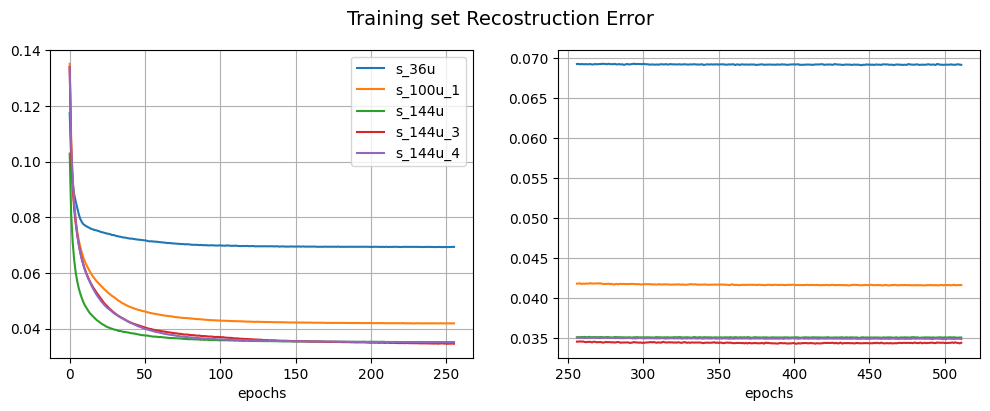

In [ ]:
data = {rbm_names[i] : x['metrics']['tr_error'] for i, x in enumerate(stats_list)}
title='Training set Recostruction Error'

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle(title, fontsize=14)

len_array = int(len(data[rbm_names[0]])/2)
x = np.array(list(range(len_array)))
# Plotting
for key in data:
    axs[0].plot(x, data[key][:len_array], label=key)
# Adding labels and title
axs[0].set_xlabel('epochs')

# Plotting
for key in data:
    axs[1].plot(len_array + x, data[key][len_array:], label=key)
# Adding labels and title
axs[1].set_xlabel('epochs')

# Adding legend
axs[0].legend()
axs[0].grid()
axs[1].grid()

# Displaying the plot
plt.show()

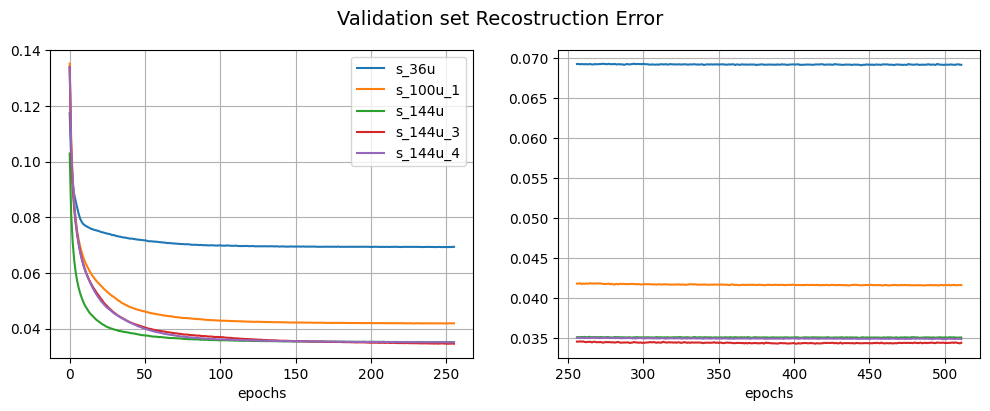

In [ ]:
data = {rbm_names[i] : x['metrics']['val_error'] for i, x in enumerate(stats_list)}
title='Validation set Recostruction Error'

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle(title, fontsize=14)

len_array = int(len(data[key])/2)
x = np.array(list(range(len_array)))
# Plotting
for key in data:
    axs[0].plot(x, data[key][:len_array], label=key)
# Adding labels and title
axs[0].set_xlabel('epochs')

# Plotting
for key in data:
    axs[1].plot(len_array + x, data[key][len_array:], label=key)
# Adding labels and title
axs[1].set_xlabel('epochs')

# Adding legend
axs[0].legend()
axs[0].grid()
#axs[0].set_yscale('log')
#axs[1].set_yscale('log')
axs[1].grid()

# Displaying the plot
plt.show()

We immediately notice from the 2 graphs above that the reconstruction error on the training set resembles or is identical to that calculated on the test set, this phenomenon can be explained by the large amount of data and the reduced complexity of the model which may even be underfitting, but since the reconstruction error is not completely representative of our final goal this is not a problem at all, we will see further later that a low error does not imply good classification accuracy.

A measure based on the free energy of visible vectors, which is more unstable and variable but probably more representative, is shown below.

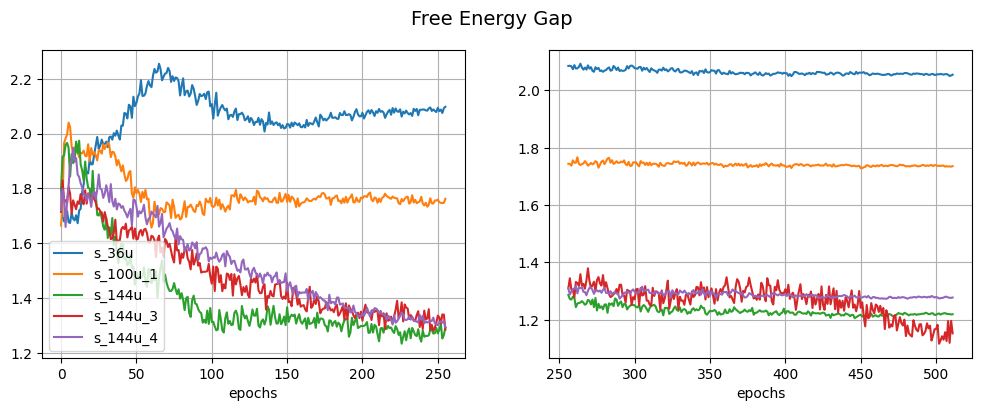

In [ ]:
data = {rbm_names[i] : x['metrics']['energy_gap'] for i, x in enumerate(stats_list)}
title='Free Energy Gap'

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle(title, fontsize=14)

len_array = int(len(data[key])/2)
x = np.array(list(range(len_array)))
# Plotting
for key in data:
    axs[0].plot(x, data[key][:len_array], label=key)
# Adding labels and title
axs[0].set_xlabel('epochs')

# Plotting
for key in data:
    axs[1].plot(len_array + x, data[key][len_array:], label=key)
# Adding labels and title
axs[1].set_xlabel('epochs')

# Adding legend
axs[0].legend()
axs[0].grid()
#axs[0].set_yscale('log')
#axs[1].set_yscale('log')
axs[1].grid()

# Displaying the plot
plt.show()

It can be seen that the curves representing the various models do not follow the order described in the previous graphs (s_144u and s_144u_3 are swapped); furthermore, looking specifically at the 3 models of 144 units, we note that:
- Small variations in the reconstruction error can correspond to large variations in the free energy difference as the 3 best-performing models, which shared the same small range in the previous graphs, are more widely spaced in this graph.
- The decay of the learning rate has a significant influence on this measure, and this can be seen by comparing the curve of models s_144u and s_144u_3, in which one stabilises from epoch 300 onwards and the second continues to undergo large variations even in advanced epochs (after 500)
- the decay of the weights did not improved the learning, in fact comparing the curves of the s_144u and s_144u_4 models, which differ only in the use of this technique, the formes obtained a better result. This is probably because the models are too small to be capable of exploit the learning improvements provided by the tecnique or because is needed a better model selection to find a good trade-off between gains and losses.

Below we show the reconstruction of some data belonging to the test set performed first by the least complex model and then by the model that achieved the minimum reconstruction error value.

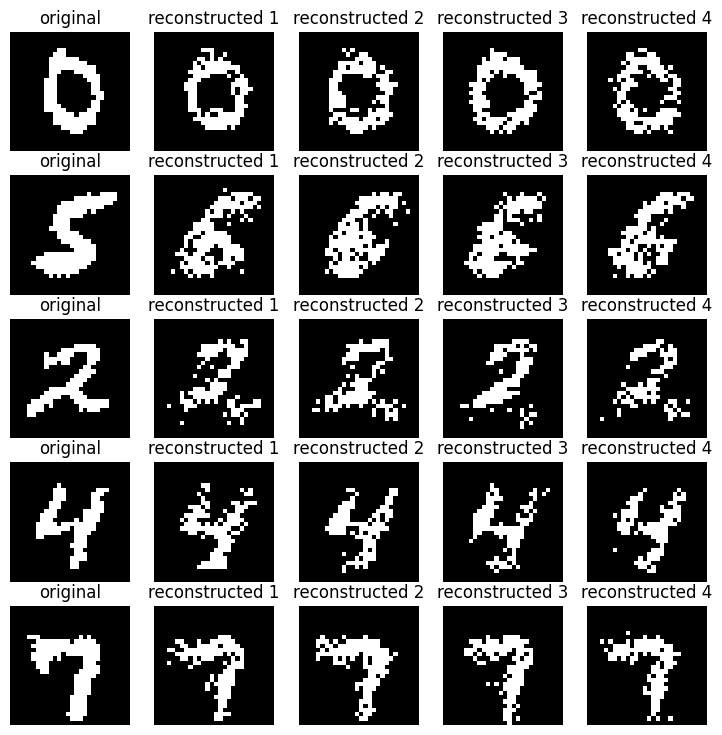

In [ ]:
rbm = RBM.deserialize(DATASET_DIR / 'RBM/s_36u.json')
to_plot = []
titles = []
n_reconstruct = 5
for i, img in enumerate(test_images):
    dummy_img = (img > np.random.rand(*img.shape)).astype(int)
    for j in range(n_reconstruct):
        to_plot.append(dummy_img)
        if j == 0:
            titles.append('original')
        else:
            titles.append('reconstructed ' + str(j))
        dummy_img = np.reshape(rbm.reconstruct(dummy_img.flatten()), (28,28))

plot_images(to_plot, titles, 5, 5, figsize=(9,9),cmap='grey')

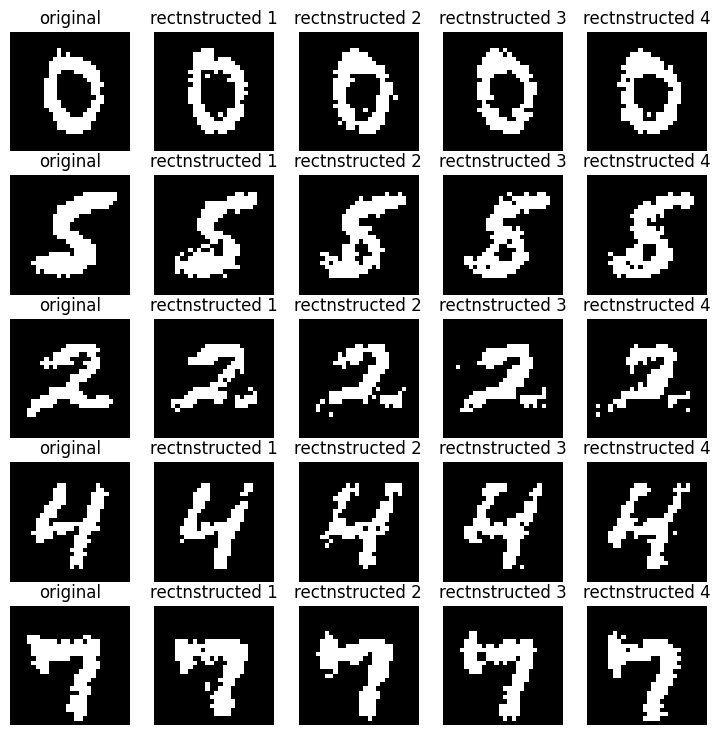

In [ ]:
rbm = RBM.deserialize(DATASET_DIR / 'RBM/s_144u_3.json')
to_plot = []
titles = []
n_reconstruct = 5
for i, img in enumerate(test_images):
    dummy_img = (img > np.random.rand(*img.shape)).astype(int)
    for j in range(n_reconstruct):
        to_plot.append(dummy_img)
        if j == 0:
            titles.append('original')
        else:
            titles.append('rectnstructed ' + str(j))
        dummy_img = np.reshape(rbm.reconstruct(dummy_img.flatten()), (28,28))

plot_images(to_plot, titles, 5, 5, figsize=(9,9), cmap='grey')

It is easy to see that the former, although it broadly retains the structure of the figure produces a much noisier and more distorted result than the reconstructions computed by the latter model, which retain many more distinctive features of the sample even after several cycles of reconstruction

Below we try to generate a figure, with little success, from a random state vector of hidden units. The failure is because in this way we are producing an image that presents features representative of several classes in the model and not just one of them. To generate images more effectively one could first understand which features in latent space are associated with which classes and then generate a random vector of weights relative to this information.

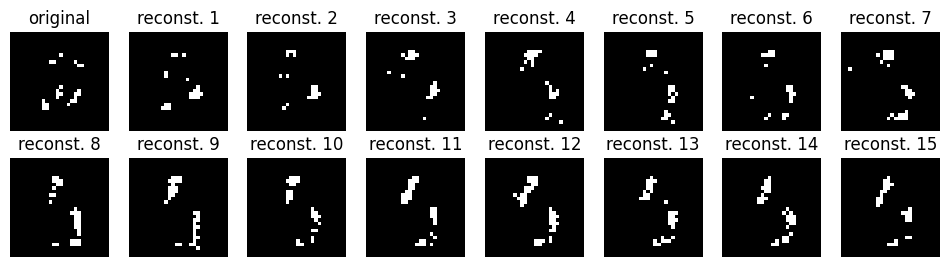

In [ ]:
to_plot = []
titles = []
n_reconstruct = 16
dummy_img = np.reshape((rbm.decode((np.random.rand(12*12) > np.random.rand(12*12)).astype(int))), (28,28))
for i in range(n_reconstruct):
    to_plot.append(dummy_img)
    if i == 0:
        titles.append('original')
    else:
        titles.append('reconst. ' + str(i))
    dummy_img = np.reshape(rbm.reconstruct(dummy_img.flatten()), (28,28))

plot_images(to_plot, titles, 2, 8, figsize=(12,3), cmap='grey')

Here we can observe a visible representation of the weights learned from the RBM. Although it is not always clear, is possible to see how each of them represents a characteristic feature of the images in the dataset, such as a straight or curved segment positioned at a certain point in the image, or a blob of pixels always in a certain posisition, etc.

Recall that in general, these weights will send a greater signal if the analyzed image resembles the weight itself, that is, if white pixels of the image correspond to white pixels of the weight in greater quantity.

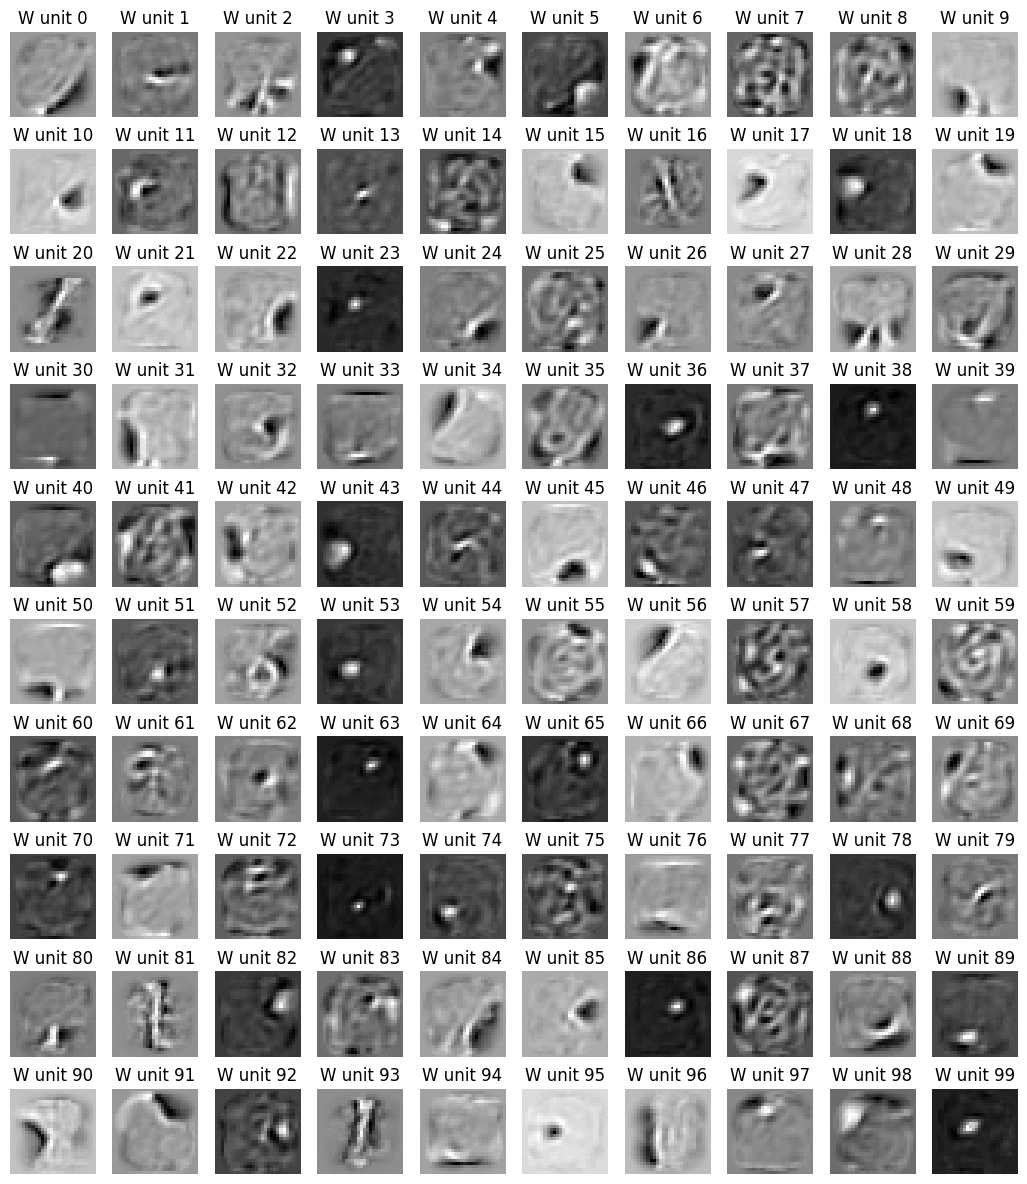

In [ ]:
rbm = RBM.deserialize(DATASET_DIR / 'RBM/s_100u.json')
to_plot = []
titles = []
n_reconstruct = 5
for i, w in enumerate(rbm.W.T):
    dummy_img = i
    to_plot.append(np.reshape(w.copy(), (28,28)))
    titles.append(f'W unit {i}')

plot_images(to_plot, titles, 10, 10, figsize=(13,15), cmap='grey')

Instead below, just for the sake of showing it, we can visualize the vector of visible unit biases.

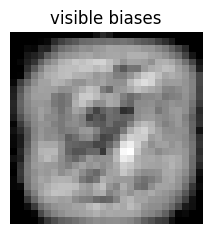

In [ ]:
plot_images([np.reshape(rbm.v_b.copy(), (28,28))], ['visible biases'], 1, 1, figsize=(2.5, 2.5), cmap='grey')

# Classification

In conclusion, we perform the last step of the study: to train a simple classifier on the test set encoding performed by RBM to classify the images into the corresponding digits (the classes are the digits form 0 to 9).

We chose to use two of the simplest existing classifiers, but that operate on very different bases. The first is a decision tree, a machine learning model that classifies samples following a decision tree, where each node represents a feature of the input data and each branch represents a possible choice based on that feature. The second is a linear Support Vector Machine, which operates the optimal hyperplane that best separates the different classes in the input data space. This hyperplane is positioned to maximise the margin.

After training the calssifiers and calculating the predictions on training set and test set, we calculate accuracy and f1-score (with macroaverage) in order to rank the results.

In [ ]:
rbm_names = ['s_36u', 's_100u_1', 's_144u', 's_144u_3', 's_144u_4']
rbm_list = [RBM.deserialize(DATASET_DIR / pth.Path('RBM/' + name + '.json')) for name in rbm_names]
classifiers = [
    skt.DecisionTreeClassifier(max_depth=12),
    sks.SVC(kernel="linear", C=0.075),
]
classifiers_name = ['decision_tree', 'linear_SVM']
index = ['training_accuracy', 'training_f1_score', 'test_accuracy', 'test_f1_score']
results = {}
training_pred = {}
test_pred = {}

for i, clf in enumerate(classifiers):
    for j, rbm in enumerate(rbm_list):
        final_name = 'RBM ' + rbm_names[j] + ' + ' + classifiers_name[i]
        results[final_name] = []

        e_training_set = rbm.encode(training_set)
        start_time = time.time()
        clf = clf.fit(e_training_set, training_lables)
        print(final_name, f'training time: {time.time() - start_time:.2f}s', )

        pred_tr_lables = clf.predict(rbm.encode(training_set))
        training_pred[final_name] = pred_tr_lables
        results[final_name].append(skm.accuracy_score(training_lables, pred_tr_lables))
        results[final_name].append(skm.f1_score(training_lables, pred_tr_lables, average='macro'))

        pred_test_lables = clf.predict(rbm.encode(test_set))
        test_pred[final_name] = pred_test_lables
        results[final_name].append(skm.accuracy_score(test_lables, pred_test_lables))
        results[final_name].append(skm.f1_score(test_lables, pred_test_lables, average='macro'))

results = pd.DataFrame(data=results, index=index).T

RBM s_36u + decision_tree training time: 0.19s
RBM s_100u_1 + decision_tree training time: 0.74s
RBM s_144u + decision_tree training time: 1.13s
RBM s_144u_3 + decision_tree training time: 1.14s
RBM s_144u_4 + decision_tree training time: 1.13s
RBM s_36u + linear_SVM training time: 23.11s
RBM s_100u_1 + linear_SVM training time: 44.20s
RBM s_144u + linear_SVM training time: 46.25s
RBM s_144u_3 + linear_SVM training time: 46.35s
RBM s_144u_4 + linear_SVM training time: 47.53s


First we show the results obtained from combining the 5 models with the decision tree, The maximum f1-score is 0.8659 obtained by the model s_100u and immediately below is s_36u with a score of 0.8657.

We note that although the more complex models have undoubtedly achieved better data reconstruction capability, we do not achieve the best classification with them. This is probably motivated by how the classifier makes decisions: for a good calssification the decision tree needs few features that are very representative of the classes, so in the case of a few total features in latent spaces it is natural that they are more representative, although a larger number of them can lead, if exploited all of them, to more accurate decisions.

In [ ]:
results.iloc[:5].style.background_gradient(cmap='Blues')

,training_accuracy,training_f1_score,test_accuracy,test_f1_score
RBM s_36u + decision_tree,0.874433,0.872759,0.867700,0.865905
RBM s_100u_1 + decision_tree,0.873450,0.872171,0.867600,0.865739
RBM s_144u + decision_tree,0.856150,0.855314,0.852200,0.851022
RBM s_144u_3 + decision_tree,0.850233,0.849529,0.850700,0.849712
RBM s_144u_4 + decision_tree,0.852267,0.851158,0.853000,0.851860


As for combining the models with SVM the best f1-score is 0.9377 obtained by the model s_144u.

We note that now, thanks to the SVM decision method, all features are exploited for classification, and as expected, the more complex models performed better. One interesting aspect should be noted: all the classifiers based on 144 hidden unit models performed very well, with scores above 0.93, and differed little, so it is complicated to make assumptions about the techniques used from these results.

In [ ]:
results.iloc[5:].style.background_gradient(cmap='Blues')

,training_accuracy,training_f1_score,test_accuracy,test_f1_score
RBM s_36u + linear_SVM,0.883517,0.881528,0.890200,0.888131
RBM s_100u_1 + linear_SVM,0.920917,0.919771,0.923600,0.922475
RBM s_144u + linear_SVM,0.937767,0.936920,0.938600,0.937761
RBM s_144u_3 + linear_SVM,0.937517,0.936692,0.937100,0.936275
RBM s_144u_4 + linear_SVM,0.931500,0.930504,0.932000,0.931007


In [ ]:
best_classifier = results.T.idxmax(axis='columns')['test_f1_score']
best_classifier

'RBM s_144u + linear_SVM'

Below we show the confusion matrix of the classifier that achieved a better result.

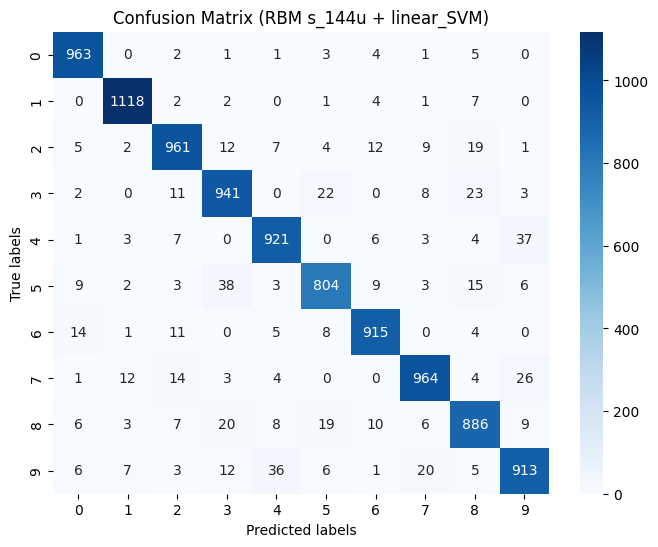

In [ ]:
# Create confusion matrix
cm = skm.confusion_matrix(test_lables, test_pred[best_classifier])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_lables), yticklabels=np.unique(test_pred[best_classifier]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (' + best_classifier + ')')
plt.show()

From the matrix we learn that the class predicted most accurately is 1 and that among the most frequent classifier errors we have 3 predicted instead of 5 and 4 predicted instead of 9.

Finally we show randomly drawn samples from the test set, first among correctly classified paterns and then among missclassified patterns

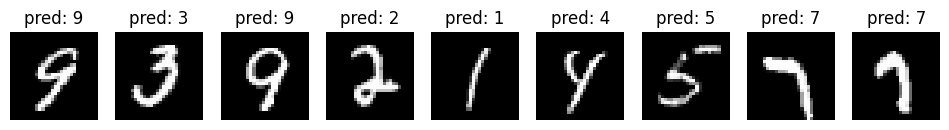

In [ ]:
# Find misclassified indices
misclassified_indices = np.where(test_lables == test_pred[best_classifier])[0]
samples = random.sample(list(misclassified_indices), 9)

to_plot = []
titles = []
n_reconstruct = 9
dummy_img = (np.random.rand(28, 28) > np.random.rand(28, 28)).astype(int)
for i in samples:
    to_plot.append(np.reshape(test_set[i], (28,28)))
    titles.append('pred: ' + str(test_pred[best_classifier][i]))

plot_images(to_plot, titles, 1, 9, figsize=(12,3), cmap='grey')

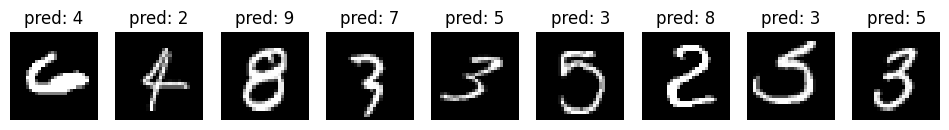

In [ ]:
# Find misclassified indices
misclassified_indices = np.where(test_lables != test_pred[best_classifier])[0]
samples = random.sample(list(misclassified_indices), 9)

to_plot = []
titles = []
n_reconstruct = 9
dummy_img = (np.random.rand(28, 28) > np.random.rand(28, 28)).astype(int)
for i in samples:
    to_plot.append(np.reshape(test_set[i], (28,28)))
    titles.append('pred: ' + str(test_pred[best_classifier][i]))

plot_images(to_plot, titles, 1, 9, figsize=(12,3), cmap='grey')

Despite the fact that misclassified patterns have an unusual structure are easily distinguishable by the human eye, we are in fact far from human accuracy in this task. We can say that the result achieved is nevertheless good as the method used has major limitations due to the non-invariance of data representation with respect to simple affine transformations (rotations, translations etc.).

# Supplementary Test

As the cherry on top of this study, we add a second, smaller analysis section, in which we apply the combinations of RBM + Classifiers used previously, to classify a second reduced test set. This new dataset reflects all the characteristics of MNIST as it contains digits, from 0 to 9, represented by 28x28 grayscale images. But it was constructed through the help of 10 students students who take the course, who were asked to write each digit 15 times, thus reaching a total of 1,500 samples, perfectly balanced across classes. The purpose of this second additional analysis is to understand whether the created model succeeds in abstracting even on this new structurally and semantically similar dataset.

We first load the new dataset into memory.

In [ ]:
if not os.path.isdir(DATASET_DIR): print('Cartella non trovata')
with open(DATASET_DIR / 'myMNIST/processed/dataset.json', 'r') as file:
    dataset = json.load(file)

images = []
labels = []
for el in dataset:
    labels.append(el['label'])
    images.append(io.imread(DATASET_DIR / pth.Path('myMNIST/processed/' + el['img_filename'])).flatten())
images = np.array([image/np.max(image) for image in images])
labels = np.array(labels)

rbm = RBM.deserialize(DATASET_DIR / pth.Path('RBM/100u_2.json'))
clf = sks.SVC(kernel="linear", C=0.025, random_state=42)
#images = np.where(images > 0.5, 1, 0)
print('Dataset len:', len(images))

Dataset len: 1500


We can immediately see that the new dataset differs from the original one in mean position and shape of the digits, but potentially less than might be expected.

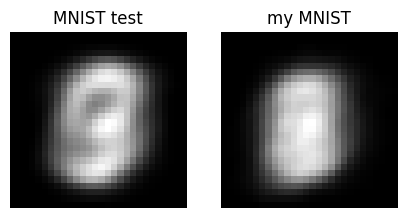

In [ ]:
MNIST_test = np.sum(test_set, axis=0) / len(test_set) + 0.5 / len(test_set)
myMNIST_test = np.sum(images, axis=0) / len(images) + 0.5 / len(images)
plot_images([np.reshape(x, (28,28)) for x in [MNIST_test,myMNIST_test]],
            ['MNIST test', 'my MNIST'], 1, 2, figsize=(5,2.5), cmap='grey')

In [ ]:
e_training_set = rbm.encode(training_set)
clf = clf.fit(e_training_set, training_lables)
pred = clf.predict(rbm.encode(images))

And now, as done before, we train the calssifiers, perform the predictions and comment a little on the results.

In [ ]:
rbm_names = ['s_36u', 's_100u_1', 's_144u', 's_144u_3', 's_144u_4']
rbm_list = [RBM.deserialize(DATASET_DIR / pth.Path('RBM/' + name + '.json')) for name in rbm_names]
classifiers = [
    skt.DecisionTreeClassifier(max_depth=10),
    sks.SVC(kernel="linear", C=0.025),
]
classifiers_name = ['decision_tree', 'linear_SVM']
index = ['test_accuracy', 'test_f1_score']
results = {}
training_pred = {}
test_pred = {}

for i, clf in enumerate(classifiers):
    for j, rbm in enumerate(rbm_list):
        final_name = 'RBM ' + rbm_names[j] + ' + ' + classifiers_name[i]
        results[final_name] = []

        e_training_set = rbm.encode(training_set)
        clf = clf.fit(e_training_set, training_lables)

        pred_test_lables = clf.predict(rbm.encode(images))
        test_pred[final_name] = pred_test_lables
        results[final_name].append(skm.accuracy_score(labels, pred_test_lables))
        results[final_name].append(skm.f1_score(labels, pred_test_lables, average='macro'))

results = pd.DataFrame(data=results, index=index).T

More than before, the decision tree performs better with simpler models and manages to achieve an f1-score of 0.32, a decidedly poor score as a random classifier would achieve a 0.10, only slightly less. We immediately realise that the difference in the dataset, as it semantically represents the same classes, is not negligible for the classifier created. We also point out that as always, generalisation is favoured by the simplicity of the solution.

In [ ]:
results.iloc[:5].style.background_gradient(cmap='Blues')

,test_accuracy,test_f1_score
RBM s_36u + decision_tree,0.323333,0.324703
RBM s_100u_1 + decision_tree,0.296000,0.292541
RBM s_144u + decision_tree,0.264000,0.268938
RBM s_144u_3 + decision_tree,0.240000,0.241469
RBM s_144u_4 + decision_tree,0.266667,0.263551


The subsequent results mirror those achieved with the original test set only by model ranking, as the maximum f1-score achieved is also only 0.39. The difference between Decision Tree and SVM is similar to that obtained in the original test set

In [ ]:
results.iloc[5:].style.background_gradient(cmap='Blues')

,test_accuracy,test_f1_score
RBM s_36u + linear_SVM,0.350000,0.352653
RBM s_100u_1 + linear_SVM,0.374000,0.375583
RBM s_144u + linear_SVM,0.386000,0.392188
RBM s_144u_3 + linear_SVM,0.378000,0.384963
RBM s_144u_4 + linear_SVM,0.365333,0.368878


In [ ]:
best_classifier = results.T.idxmax(axis='columns')['test_f1_score']
best_classifier

'RBM s_144u + linear_SVM'

Finally we show the confusion matrix and some of the correctly and incorrectly classified patterns.

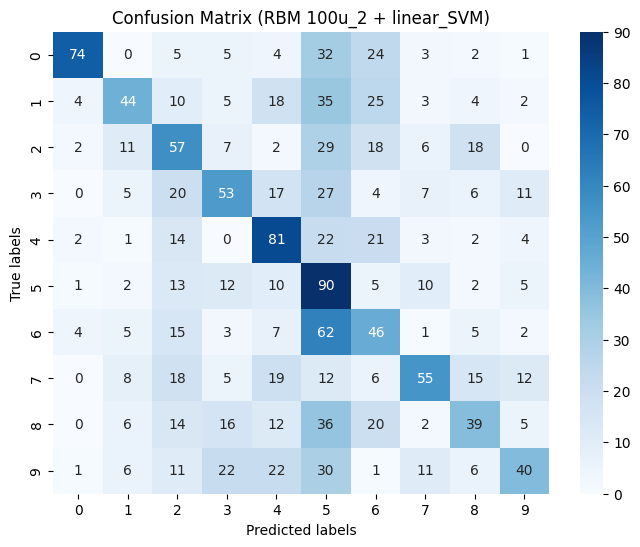

In [ ]:
cm = skm.confusion_matrix(labels, test_pred[best_classifier])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(labels), yticklabels=np.unique(test_pred[best_classifier]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (RBM 100u_2 + linear_SVM)')
plt.show()

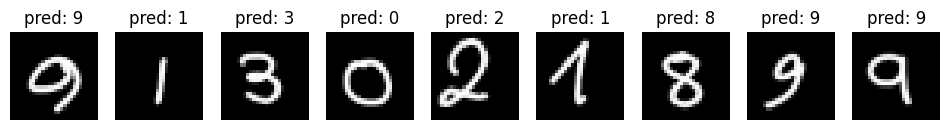

In [ ]:
# Find misclassified indices
misclassified_indices = np.where(labels == test_pred[best_classifier])[0]
samples = random.sample(list(misclassified_indices), 9)

to_plot = []
titles = []
n_reconstruct = 9
dummy_img = (np.random.rand(28, 28) > np.random.rand(28, 28)).astype(int)
for i in samples:
    to_plot.append(np.reshape(images[i], (28,28)))
    titles.append('pred: ' + str(test_pred[best_classifier][i]))

plot_images(to_plot, titles, 1, 9, figsize=(12,3), cmap='grey')

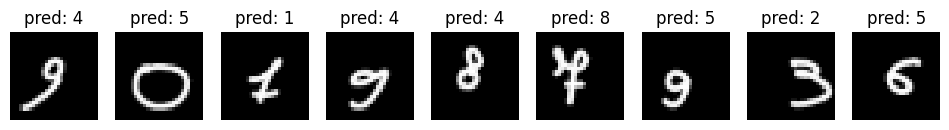

In [ ]:
# Find misclassified indices
misclassified_indices = np.where(labels != test_pred[best_classifier])[0]
samples = random.sample(list(misclassified_indices), 9)

to_plot = []
titles = []
n_reconstruct = 9
dummy_img = (np.random.rand(28, 28) > np.random.rand(28, 28)).astype(int)
for i in samples:
    to_plot.append(np.reshape(images[i], (28,28)))
    titles.append('pred: ' + str(test_pred[best_classifier][i]))

plot_images(to_plot, titles, 1, 9, figsize=(12,3), cmap='grey')

In this study, we first visualised the dataset and understood its meaning, then we implemented RBM and, with a minimum of model selection, trained different models to make comparisons. We saw that the RBM was able to learn the structure of the dataset, and this was confirmed by the third and final step of the study, which was to train a classifier to predict the class of a sample from the encoding of the sample. The results of the classification depended very much on the model used, but by using a combination of RBM with 144 hidden units and linear SVM, we exceeded the accuracy of 0.9 and thus obtained a good result. Finally, we tested the predictive ability of the model on a second dataset of a slightly different nature and found that although the test results on MNIST were good, those on the second test were not, but this is an expected result given the poor invariance of the prediction of the model built with respect to structural variations in the data.